# Training the CNN

I will train a cnn on the images of the folder Dataset, this resulting CNN will be applied to each frame of a video and will return an embedding for each frame. This will be fed into a LSTM to classify the video as either real or fake



In [1]:
import os
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn

IMG_DATA_BATCH_SIZE = 32
DEVICE = "cuda"
CLASS_THRESHOLD = 0.5
LR = 0.0001

## Image preprocessing

the images in the Dataset folder are 256x256 pixels, but the videos we are classifying with the LSTM will be preprocessed to be 64x64. For this reason, the CNN as well will be trained on images 64x64. The following code will resize the dataset and prepare the dataloader object to train the CNN


In [16]:
import torch
from torchvision.io import read_image
from torchvision.transforms.functional import resize
import os
from tqdm import tqdm

def resize_image(img_path):
    img = read_image(img_path)
    return resize(img, size = [64,64])

# testing the function
# import matplotlib.pyplot as plt
# before = read_image("Dataset/Validation/fake/fake_0.jpg")
# after = resize_image("Dataset/Validation/fake/fake_0.jpg")
# fig, axes = plt.subplots(nrows= 1, ncols= 2)
# axes = axes.flatten()
# axes[0].imshow(before.permute(1,2,0))
# axes[1].imshow(after.permute(1,2,0))

def resize_dataset(output_dir):
    for subset in ['Train', 'Validation', 'Test']:
        for class_name in ['real', 'fake']:
            input_dir = os.path.join("Dataset", subset, class_name)
            new_output_dir = os.path.join(output_dir, subset, class_name)
            os.makedirs(new_output_dir, exist_ok=True)
            
            img_files = [f for f in os.listdir(input_dir) if f.endswith('.jpg')]
            
            for img_file in tqdm(img_files, desc=f"Processing {subset} {class_name}"):
                video_path = os.path.join(input_dir, img_file)
                processed_image = resize_image(video_path)
                
                output_path = os.path.join(new_output_dir, img_file.replace('.jpg', '.pth'))
                torch.save(processed_image, output_path)

# resize_dataset("..\\resized_images")

Processing Test fake: 100%|██████████| 5492/5492 [00:15<00:00, 355.21it/s]


## Datasets and Data loaders

In [1]:
class ImageDataset(Dataset):

    def __init__(self, processed_dir = "../resized_images", subset = "Train", batch_size = IMG_DATA_BATCH_SIZE, device = DEVICE):
        self.directory = processed_dir+"/"+subset
        self.batch_size = batch_size
        self.device = device
        self.images = self._get_img_paths()
        self._shuffle_data()
        self.length = int(len(self.images)/self.batch_size) + 1
    
    def _get_img_paths(self):
        imgs = []
        for img_path in os.listdir(self.directory + "/Fake"):
            imgs.append((self.directory + "/Fake/"+img_path, 1))
        for img_path in os.listdir(self.directory + "/Real"):
            imgs.append((self.directory + "/Real/"+img_path, 0))
        return imgs
    
    def _shuffle_data(self):
        np.random.shuffle(self.images)
    
    def __getitem__(self,index):
        images = []
        labels = []
        for img, label in self.images[index*self.batch_size:(index+1)*self.batch_size]:
            labels.append(label)
            images.append(torch.load(img)/256)
            x = torch.stack(images).to(self.device)
            y = torch.tensor(labels).to(self.device).to(torch.float32)
        return x, y
    
    def __len__(self):
        return self.length
    

val_img_dataset = ImageDataset(subset="Validation", batch_size= IMG_DATA_BATCH_SIZE, device = DEVICE)
train_img_dataset = ImageDataset(subset="Train", batch_size= IMG_DATA_BATCH_SIZE, device = DEVICE)

val_img_loader = DataLoader(val_img_dataset, batch_size= None, collate_fn= lambda x: x)
train_img_loader = DataLoader(train_img_dataset, batch_size= None, collate_fn= lambda x: x)

## Training function

In [2]:
def train_loop(model, epochs, train_loader, val_loader, class_threshold = CLASS_THRESHOLD):

    history = dict()

    for e in range(1,epochs+1):

        model.train()
        print("-"*40+f"|EPOCH {e}|"+"-"*40)
        losses = []
        for batch, (x,y) in tqdm(enumerate(train_loader),desc = "Training loop"):
            pred_proba, _ = model(x)
            loss_value = model.loss_function(pred_proba,y)
            losses.append(loss_value.item())
            loss_value.backward()
            model.optimizer_function.step()
            model.optimizer_function.zero_grad()
        print(f"Train Loss: {np.mean(losses):.5f} | Progress: [{batch+1}/{len(train_loader)}]")
        history[f"train_loss_epoch_{e}"] = losses
        
        model.eval()
        loss, correct, val_size = 0,0,0
        with torch.no_grad():
             for x,y in tqdm(val_loader, desc= "Validation Loop"):
                  val_size += y.shape[0]
                  pred_proba, _ = model(x)
                  loss += model.loss_function(pred_proba,y)
                  pred_class = (pred_proba > class_threshold).type(torch.float)
                  correct += (pred_class == y).type(torch.float).sum().item()
        print(f"Validation Accuracy {(correct/val_size):.2%} | Validation Loss {(loss/len(val_loader)):6f} | Train Loss {np.mean(losses):.5f}")
        history[f"val_loss_epoch_{e}"] = loss.item()
        history[f"val_correct_epoch_{e}"] = correct
        history[f"val_size_epoch_{e}"] = val_size

        train_loader.dataset._shuffle_data()
        val_loader.dataset._shuffle_data()

    for key, value in history.items():
        if isinstance(value, list):
            history[key] = np.mean(value).item()
    
    return history

## Model class

In [2]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class DF_img_detector(nn.Module):

    def __init__(self, sequence, final_layer,
                 loss_function,
                 optimizer_constructor,
                 optimizer_kwargs = {"lr": LR}):
        super(DF_img_detector, self).__init__()
        self.sequence = sequence
        self.final_layer = final_layer
        self.loss_function = loss_function
        self.optimizer_function = optimizer_constructor(self.parameters(),**optimizer_kwargs)
        self.to(DEVICE)
    
    def forward(self, x):
        embedding = self.sequence(x)
        p_hat = self.final_layer(embedding)
        return p_hat.flatten(), embedding
    
sequence = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels= 16, kernel_size= 3, padding="valid"),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=16, out_channels= 32, kernel_size= 3, padding="valid"),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=32, out_channels= 64, kernel_size= 5, padding="valid"),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=256),
    nn.ReLU(),
    nn.Dropout(0.1)
)

final_layer = nn.Sequential(
    nn.Linear(256,1),
    nn.Sigmoid()
)

model_0 = DF_img_detector(sequence= sequence, final_layer= final_layer,
                          loss_function= nn.BCELoss(),
                          optimizer_constructor= torch.optim.Adam)

print("number of parameter: ",count_parameters(model_0))
for name, param in model_0.named_parameters():
    print(f'{name}: {param.dtype}, params: {param.numel()}')

number of parameter:  466465
sequence.0.weight: torch.float32, params: 432
sequence.0.bias: torch.float32, params: 16
sequence.4.weight: torch.float32, params: 4608
sequence.4.bias: torch.float32, params: 32
sequence.8.weight: torch.float32, params: 51200
sequence.8.bias: torch.float32, params: 64
sequence.13.weight: torch.float32, params: 409600
sequence.13.bias: torch.float32, params: 256
final_layer.0.weight: torch.float32, params: 256
final_layer.0.bias: torch.float32, params: 1


## Training the Model

In [4]:
history = train_loop(model_0, epochs= 15,
           train_loader= train_img_loader,
           val_loader=val_img_loader)
torch.save(model_0, 'pytorch models/pretrainedCNN_15_e.pth')

----------------------------------------|EPOCH 1|----------------------------------------


Training loop: 4376it [01:57, 37.10it/s]


Train Loss: 0.46408 | Progress: [4376/4376]


Validation Loop: 100%|██████████| 1233/1233 [00:31<00:00, 39.56it/s]


Validation Accuracy 77.91% | Validation Loss 0.479638 | Train Loss 0.46408
----------------------------------------|EPOCH 2|----------------------------------------


Training loop: 4376it [01:57, 37.31it/s]


Train Loss: 0.36096 | Progress: [4376/4376]


Validation Loop: 100%|██████████| 1233/1233 [00:30<00:00, 39.86it/s]


Validation Accuracy 82.78% | Validation Loss 0.402225 | Train Loss 0.36096
----------------------------------------|EPOCH 3|----------------------------------------


Training loop: 4376it [01:59, 36.77it/s]


Train Loss: 0.30855 | Progress: [4376/4376]


Validation Loop: 100%|██████████| 1233/1233 [00:30<00:00, 41.10it/s]


Validation Accuracy 84.57% | Validation Loss 0.355804 | Train Loss 0.30855
----------------------------------------|EPOCH 4|----------------------------------------


Training loop: 4376it [01:57, 37.12it/s]


Train Loss: 0.27658 | Progress: [4376/4376]


Validation Loop: 100%|██████████| 1233/1233 [00:31<00:00, 39.29it/s]


Validation Accuracy 85.70% | Validation Loss 0.334767 | Train Loss 0.27658
----------------------------------------|EPOCH 5|----------------------------------------


Training loop: 4376it [04:53, 14.92it/s]


Train Loss: 0.25101 | Progress: [4376/4376]


Validation Loop: 100%|██████████| 1233/1233 [04:57<00:00,  4.15it/s]


Validation Accuracy 86.76% | Validation Loss 0.308589 | Train Loss 0.25101
----------------------------------------|EPOCH 6|----------------------------------------


Training loop: 4376it [12:07,  6.02it/s]


Train Loss: 0.22939 | Progress: [4376/4376]


Validation Loop: 100%|██████████| 1233/1233 [00:31<00:00, 39.57it/s]


Validation Accuracy 88.30% | Validation Loss 0.280704 | Train Loss 0.22939
----------------------------------------|EPOCH 7|----------------------------------------


Training loop: 4376it [02:01, 36.05it/s]


Train Loss: 0.21341 | Progress: [4376/4376]


Validation Loop: 100%|██████████| 1233/1233 [00:30<00:00, 40.38it/s]


Validation Accuracy 88.97% | Validation Loss 0.265870 | Train Loss 0.21341
----------------------------------------|EPOCH 8|----------------------------------------


Training loop: 4376it [01:58, 36.87it/s]


Train Loss: 0.19833 | Progress: [4376/4376]


Validation Loop: 100%|██████████| 1233/1233 [00:30<00:00, 39.88it/s]


Validation Accuracy 89.48% | Validation Loss 0.250914 | Train Loss 0.19833
----------------------------------------|EPOCH 9|----------------------------------------


Training loop: 4376it [01:59, 36.58it/s]


Train Loss: 0.18638 | Progress: [4376/4376]


Validation Loop: 100%|██████████| 1233/1233 [00:31<00:00, 39.57it/s]


Validation Accuracy 89.07% | Validation Loss 0.256030 | Train Loss 0.18638
----------------------------------------|EPOCH 10|----------------------------------------


Training loop: 4376it [02:01, 36.00it/s]


Train Loss: 0.17684 | Progress: [4376/4376]


Validation Loop: 100%|██████████| 1233/1233 [00:31<00:00, 38.87it/s]


Validation Accuracy 90.63% | Validation Loss 0.227131 | Train Loss 0.17684
----------------------------------------|EPOCH 11|----------------------------------------


Training loop: 4376it [01:56, 37.51it/s]


Train Loss: 0.16793 | Progress: [4376/4376]


Validation Loop: 100%|██████████| 1233/1233 [00:34<00:00, 35.32it/s]


Validation Accuracy 90.86% | Validation Loss 0.225541 | Train Loss 0.16793
----------------------------------------|EPOCH 12|----------------------------------------


Training loop: 4376it [01:57, 37.19it/s]


Train Loss: 0.15923 | Progress: [4376/4376]


Validation Loop: 100%|██████████| 1233/1233 [00:31<00:00, 39.24it/s]


Validation Accuracy 90.60% | Validation Loss 0.225416 | Train Loss 0.15923
----------------------------------------|EPOCH 13|----------------------------------------


Training loop: 4376it [01:58, 36.90it/s]


Train Loss: 0.15366 | Progress: [4376/4376]


Validation Loop: 100%|██████████| 1233/1233 [00:31<00:00, 38.95it/s]


Validation Accuracy 90.53% | Validation Loss 0.224838 | Train Loss 0.15366
----------------------------------------|EPOCH 14|----------------------------------------


Training loop: 4376it [01:58, 36.78it/s]


Train Loss: 0.14595 | Progress: [4376/4376]


Validation Loop: 100%|██████████| 1233/1233 [00:30<00:00, 40.40it/s]


Validation Accuracy 90.42% | Validation Loss 0.227186 | Train Loss 0.14595
----------------------------------------|EPOCH 15|----------------------------------------


Training loop: 4376it [02:00, 36.46it/s]


Train Loss: 0.14019 | Progress: [4376/4376]


Validation Loop: 100%|██████████| 1233/1233 [00:30<00:00, 41.01it/s]

Validation Accuracy 91.33% | Validation Loss 0.212663 | Train Loss 0.14019


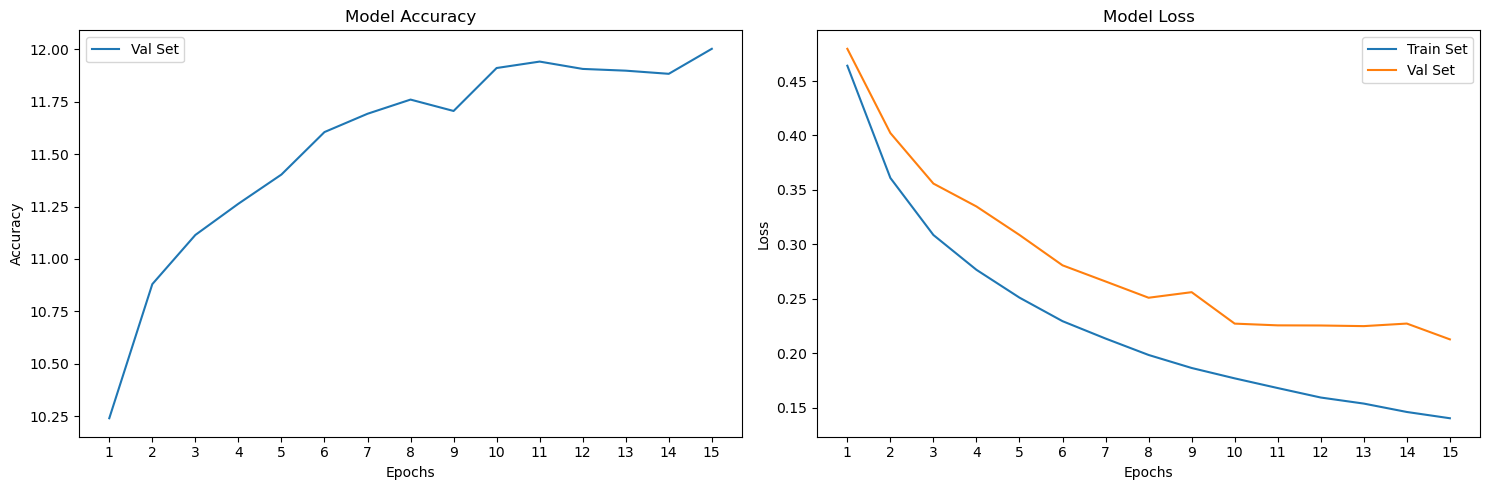

In [5]:
train_loss = []
val_accuracy = []
val_loss = []

for key, value, in history.items():
    if key.startswith("train_loss"):
        train_loss.append(value)
    if key.startswith("val_loss"):
        val_loss.append(value/len(val_img_loader))
    if key.startswith("val_correct"):
        val_accuracy.append(value/3000)

epochs = list(range(1,len(train_loss)+1))

import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(epochs, val_accuracy, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.xticks(ticks=range(1, len(epochs) + 1), 
           labels=[str(int(round(x))) for x in range(1, len(epochs) + 1)])


# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Set')
plt.plot(epochs, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.xticks(ticks=range(1, len(epochs) + 1), 
           labels=[str(int(round(x))) for x in range(1, len(epochs) + 1)])

plt.tight_layout()
plt.show()

## Classification report

100%|██████████| 1233/1233 [00:31<00:00, 39.47it/s]


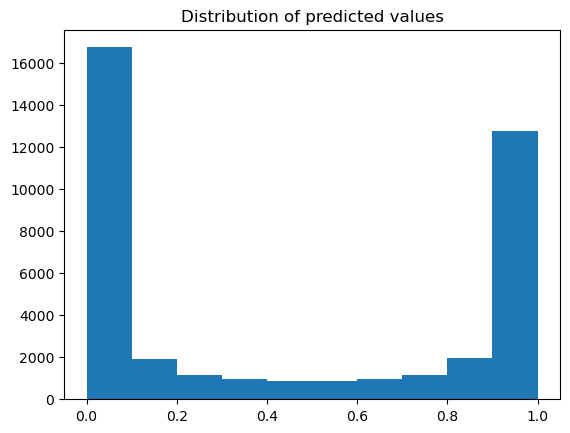

In [6]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

model_0.eval()
y_true = []
p_hats = []

with torch.no_grad():
    for x,y in tqdm(val_img_loader):
        p_hat, _ = model_0(x)
        p_hats.append(p_hat.to("cpu"))
        y_true.append(y.to("cpu"))

y_true = torch.cat(y_true).numpy()
p_hats = torch.cat(p_hats).numpy()
plt.hist(p_hats)
plt.title("Distribution of predicted values")
plt.show()

In [7]:
print(f"Validation accuracy: {accuracy_score(y_true, p_hats > 0.5)}")

print(f"Area under the curve of validation set: {roc_auc_score(y_true, p_hats)}")

print("Confusion matrix on validation set with threshold 0.5\n",confusion_matrix(y_true,  p_hats > 0.5))

print("Classification Report on validation set, t = 0.5\n",classification_report(y_true, p_hats > 0.5))

Validation accuracy: 0.9132596124581516
Area under the curve of validation set: 0.9768696693097512
Confusion matrix on validation set with threshold 0.5
 [[19024   763]
 [ 2657 16984]]
Classification Report on validation set, t = 0.5
               precision    recall  f1-score   support

         0.0       0.88      0.96      0.92     19787
         1.0       0.96      0.86      0.91     19641

    accuracy                           0.91     39428
   macro avg       0.92      0.91      0.91     39428
weighted avg       0.92      0.91      0.91     39428



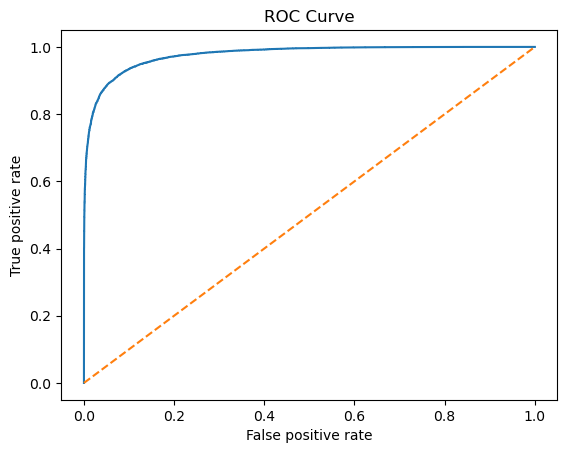

In [8]:
fpr, tpr, t = roc_curve(y_true, p_hats)

plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], "--")
plt.title("ROC Curve")
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.show()

# LSTM with pretrained CNN

Now we can build the LSTM network that takes as input the frames of a video embedded as the vector of size 256 produced by the CNN we just trained

In [3]:
PROCESSED_DIR = "../Processed_data"
DEVICE = "cuda"
BATCH_SIZE = 32

CLASS_THRESHOLD = 0.5

LR = 0.0001


## Video Datasets and Dataloaders

In [4]:
class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, processed_dir = "../Processed_data", subset = "Train", batch_size = 32, device = "cuda"):
        self.directory = processed_dir+"/"+subset
        self.batch_size = batch_size
        self.subset = subset
        self.device = device

        self.videos = self._get_video_paths()
        self._shuffle_data()

        self.length = int(len(self.videos)/self.batch_size) + 1
    
    def _get_video_paths(self):
        videos = []
        for filename in os.listdir(self.directory + "/real"):
            if filename.endswith(".npy"):
                videos.append((self.directory + "/real/"+ filename,0))
        for filename in os.listdir(self.directory + "/fake"):
            if filename.endswith(".npy"):
                videos.append((self.directory + "/fake/"+ filename,1))
        return videos
    
    def _shuffle_data(self):
        np.random.shuffle(self.videos)
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        #this function will return an array of the following shape:
        #(batch_size, n_frames, n_channels, height, width)
        # and a vector of length batch_size that indicates the 
        # class: 0 for real videos, 1 for fake videos
        features = []
        targets = []
        for video_path, label in self.videos[index*self.batch_size:(index+1)*self.batch_size]:
            array = torch.from_numpy(np.load(video_path)).permute(0, 3, 1, 2).to(self.device).to(torch.float32)
            # To work with nn.Conv2d the dimension that indicates channels 
            # #has to be the third one, not the last one
            features.append(array)
            targets.append(label)
        return torch.stack(features), torch.tensor(targets).to(self.device).to(torch.float32)
    

# dataset objects
video_train_dataset = VideoDataset(processed_dir = PROCESSED_DIR, subset= "Train", batch_size= BATCH_SIZE, device= DEVICE)
video_val_dataset = VideoDataset(processed_dir = PROCESSED_DIR, subset= "Val", batch_size= BATCH_SIZE, device= DEVICE)

# making the dataloader objects
# the parameters batch size and collate fn have to be this way, do not change them
video_train_dataloader = torch.utils.data.DataLoader(video_train_dataset, batch_size= None, collate_fn= lambda x: x)
video_val_dataloader = torch.utils.data.DataLoader(video_val_dataset, batch_size= None, collate_fn= lambda x: x)

## Traning function and  Full Model

In [5]:
def train_loop(model, epochs, train_loader, val_loader, class_threshold = CLASS_THRESHOLD):

    history = dict()

    for e in range(1,epochs+1):

        model.train()
        print("-"*40+f"|EPOCH {e}|"+"-"*40)
        losses = []
        for batch, (x,y) in tqdm(enumerate(train_loader),desc = "Training loop"):
            pred_proba = model(x)
            loss_value = model.loss_function(pred_proba,y)
            losses.append(loss_value.item())
            loss_value.backward()
            model.optimizer_function.step()
            model.optimizer_function.zero_grad()
        print(f"Train Loss: {np.mean(losses):.5f} | Progress: [{batch+1}/{len(train_loader)}]")
        history[f"train_loss_epoch_{e}"] = losses
        
        model.eval()
        loss, correct, val_size = 0,0,0
        with torch.no_grad():
             for x,y in tqdm(val_loader, desc= "Validation Loop"):
                  val_size += y.shape[0]
                  pred_proba = model(x)
                  loss += model.loss_function(pred_proba,y)
                  pred_class = (pred_proba > class_threshold).type(torch.float)
                  correct += (pred_class == y).type(torch.float).sum().item()
        print(f"Validation Accuracy {(correct/val_size):.2%} | Validation Loss {(loss/len(val_loader)):6f} | Train Loss {np.mean(losses):.5f}")
        history[f"val_loss_epoch_{e}"] = loss.item()
        history[f"val_correct_epoch_{e}"] = correct
        history[f"val_size_epoch_{e}"] = val_size

        torch.save(model, f'pytorch models/double_lstm/double_lstm_pretrained_cnn_{e}_e.pth')
        train_loader.dataset._shuffle_data()
        val_loader.dataset._shuffle_data()

    for key, value in history.items():
        if isinstance(value, list):
            history[key] = np.mean(value).item()
    
    return history

In [6]:
# loading the model and setting its parameters to not keep gradients
pretrained_cnn = torch.load('pytorch models/pretrainedCNN_15_e.pth')
for param in pretrained_cnn.parameters():
    param.requires_grad = False

# now copying the code I wrote in rnn_pytorch.ipynb

# first I define the two classes I need:

# defining the time distributed class
# returns an embedding for each temporal slice of the input

class TimeDistributed(nn.Module):
    '''
    This object takes a layer or a sequence of layers and applies it to each individual temporal slice of an input.
    It returns the embedding produced by the given layers for each temporal slice for each data point in the batch
    '''
    def __init__(self,layer):
        super(TimeDistributed,self).__init__()
        self.layer = layer
    
    def forward(self, x):
        batch_size, t_slices , *slice_dims = x.shape
        x = x.reshape(batch_size*t_slices, *slice_dims)
        p_hat, embedding = self.layer(x)
        output_batches, *embedding_shape = embedding.shape
        assert output_batches == batch_size * t_slices, f"Wrong Number of batches in the output: the layers inside TimeDistributed should output {batch_size * t_slices} batches, but got {output_batches} instead"
        embedding = embedding.reshape((batch_size, t_slices, *embedding_shape))
        p_hat = p_hat.reshape((batch_size, t_slices))
        return p_hat, embedding
    

# Defining the RNN that detects deepfake videos
class DeepFakeDetector(nn.Module):
    def __init__(self, cnn, rnn, sequence, loss_function,
                 optimizer_constructor,
                 optimizer_kwargs = {"lr": LR},
                 scheduler = False):
        super(DeepFakeDetector, self).__init__()
        self.t_dist_cnn = TimeDistributed(cnn)
        self.rnn = rnn
        self.sequence = sequence
        self.loss_function = loss_function
        self.optimizer_function = optimizer_constructor(self.parameters(),**optimizer_kwargs)
        self.scheduler = scheduler
        self.to(DEVICE)
    
    def forward(self, x):
        # input x has shape [batch_size, n_frames, n_channels, frame_H, frame_W]
        p_hat, embedded_frames = self.t_dist_cnn(x)

        self.rnn.flatten_parameters()
        #adding this line because it was giving a warning

        rnn_out, (h_n, c_n) = self.rnn(embedded_frames)
        # from the rnn we only take the final cell state
        
        pred_proba = self.sequence(c_n[-1,:, :])
        # a vector of length batch_size
        return pred_proba.flatten()
    

# defining the rnn that takes the output of time distributed cnn
rnn = nn.LSTM(input_size=256, hidden_size= 256,
              num_layers= 2, batch_first= True)

# now we can build the complete network

lstm_pretrained_cnn = DeepFakeDetector(cnn = pretrained_cnn, rnn = rnn,
                             sequence=nn.Sequential(
                                 nn.Linear(in_features=256, out_features=128),
                                 nn.ReLU(),
                                 nn.Dropout(0.1),
                                 nn.Linear(in_features=128, out_features=64),
                                 nn.ReLU(),
                                 nn.Dropout(0.1),
                                 nn.Linear(64,1),
                                 nn.Sigmoid()),
                             loss_function=nn.BCELoss(),
                             optimizer_constructor= torch.optim.Adam)


print("number of parameter: ",count_parameters(lstm_pretrained_cnn))

# Verify the data types of the parameters
for name, param in lstm_pretrained_cnn.named_parameters():
    print(f'{name}: {param.dtype}, params: {param.numel()}, require grad: {param.requires_grad}')

number of parameter:  1093889
t_dist_cnn.layer.sequence.0.weight: torch.float32, params: 432, require grad: False
t_dist_cnn.layer.sequence.0.bias: torch.float32, params: 16, require grad: False
t_dist_cnn.layer.sequence.4.weight: torch.float32, params: 4608, require grad: False
t_dist_cnn.layer.sequence.4.bias: torch.float32, params: 32, require grad: False
t_dist_cnn.layer.sequence.8.weight: torch.float32, params: 51200, require grad: False
t_dist_cnn.layer.sequence.8.bias: torch.float32, params: 64, require grad: False
t_dist_cnn.layer.sequence.13.weight: torch.float32, params: 409600, require grad: False
t_dist_cnn.layer.sequence.13.bias: torch.float32, params: 256, require grad: False
t_dist_cnn.layer.final_layer.0.weight: torch.float32, params: 256, require grad: False
t_dist_cnn.layer.final_layer.0.bias: torch.float32, params: 1, require grad: False
rnn.weight_ih_l0: torch.float32, params: 262144, require grad: True
rnn.weight_hh_l0: torch.float32, params: 262144, require grad: 

## Training the full model

In [7]:
history = train_loop(lstm_pretrained_cnn, epochs= 30,
           train_loader= video_train_dataloader,
           val_loader=video_val_dataloader)


----------------------------------------|EPOCH 1|----------------------------------------


Training loop: 438it [01:49,  4.00it/s]


Train Loss: 0.68099 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  7.88it/s]


Validation Accuracy 58.00% | Validation Loss 0.672546 | Train Loss 0.68099
----------------------------------------|EPOCH 2|----------------------------------------


Training loop: 438it [00:51,  8.46it/s]


Train Loss: 0.65115 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.41it/s]


Validation Accuracy 63.33% | Validation Loss 0.640185 | Train Loss 0.65115
----------------------------------------|EPOCH 3|----------------------------------------


Training loop: 438it [00:51,  8.47it/s]


Train Loss: 0.60676 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.47it/s]


Validation Accuracy 66.10% | Validation Loss 0.611322 | Train Loss 0.60676
----------------------------------------|EPOCH 4|----------------------------------------


Training loop: 438it [00:52,  8.38it/s]


Train Loss: 0.55188 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.41it/s]


Validation Accuracy 67.20% | Validation Loss 0.602939 | Train Loss 0.55188
----------------------------------------|EPOCH 5|----------------------------------------


Training loop: 438it [00:52,  8.41it/s]


Train Loss: 0.49196 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.47it/s]


Validation Accuracy 75.40% | Validation Loss 0.500684 | Train Loss 0.49196
----------------------------------------|EPOCH 6|----------------------------------------


Training loop: 438it [00:50,  8.60it/s]


Train Loss: 0.45737 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.37it/s]


Validation Accuracy 77.10% | Validation Loss 0.472487 | Train Loss 0.45737
----------------------------------------|EPOCH 7|----------------------------------------


Training loop: 438it [00:51,  8.55it/s]


Train Loss: 0.42344 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.51it/s]


Validation Accuracy 77.43% | Validation Loss 0.462504 | Train Loss 0.42344
----------------------------------------|EPOCH 8|----------------------------------------


Training loop: 438it [00:51,  8.44it/s]


Train Loss: 0.40297 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.41it/s]


Validation Accuracy 75.57% | Validation Loss 0.479049 | Train Loss 0.40297
----------------------------------------|EPOCH 9|----------------------------------------


Training loop: 438it [00:52,  8.42it/s]


Train Loss: 0.38380 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.38it/s]


Validation Accuracy 75.77% | Validation Loss 0.497359 | Train Loss 0.38380
----------------------------------------|EPOCH 10|----------------------------------------


Training loop: 438it [00:51,  8.55it/s]


Train Loss: 0.36569 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.33it/s]


Validation Accuracy 77.97% | Validation Loss 0.448817 | Train Loss 0.36569
----------------------------------------|EPOCH 11|----------------------------------------


Training loop: 438it [00:51,  8.46it/s]


Train Loss: 0.36119 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.36it/s]


Validation Accuracy 75.57% | Validation Loss 0.480154 | Train Loss 0.36119
----------------------------------------|EPOCH 12|----------------------------------------


Training loop: 438it [00:52,  8.41it/s]


Train Loss: 0.35069 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.38it/s]


Validation Accuracy 82.47% | Validation Loss 0.384495 | Train Loss 0.35069
----------------------------------------|EPOCH 13|----------------------------------------


Training loop: 438it [00:51,  8.42it/s]


Train Loss: 0.34065 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.41it/s]


Validation Accuracy 74.20% | Validation Loss 0.527645 | Train Loss 0.34065
----------------------------------------|EPOCH 14|----------------------------------------


Training loop: 438it [00:51,  8.50it/s]


Train Loss: 0.33900 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.35it/s]


Validation Accuracy 81.03% | Validation Loss 0.399345 | Train Loss 0.33900
----------------------------------------|EPOCH 15|----------------------------------------


Training loop: 438it [00:52,  8.39it/s]


Train Loss: 0.32770 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.38it/s]


Validation Accuracy 75.13% | Validation Loss 0.510679 | Train Loss 0.32770
----------------------------------------|EPOCH 16|----------------------------------------


Training loop: 438it [00:52,  8.33it/s]


Train Loss: 0.32449 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.48it/s]


Validation Accuracy 75.23% | Validation Loss 0.489707 | Train Loss 0.32449
----------------------------------------|EPOCH 17|----------------------------------------


Training loop: 438it [00:51,  8.44it/s]


Train Loss: 0.31684 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.46it/s]


Validation Accuracy 83.60% | Validation Loss 0.371286 | Train Loss 0.31684
----------------------------------------|EPOCH 18|----------------------------------------


Training loop: 438it [00:51,  8.48it/s]


Train Loss: 0.31248 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.38it/s]


Validation Accuracy 77.60% | Validation Loss 0.489477 | Train Loss 0.31248
----------------------------------------|EPOCH 19|----------------------------------------


Training loop: 438it [00:51,  8.45it/s]


Train Loss: 0.30253 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.49it/s]


Validation Accuracy 81.17% | Validation Loss 0.403705 | Train Loss 0.30253
----------------------------------------|EPOCH 20|----------------------------------------


Training loop: 438it [00:51,  8.45it/s]


Train Loss: 0.29818 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.47it/s]


Validation Accuracy 78.33% | Validation Loss 0.434872 | Train Loss 0.29818
----------------------------------------|EPOCH 21|----------------------------------------


Training loop: 438it [00:59,  7.41it/s]


Train Loss: 0.28952 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:13<00:00,  7.01it/s]


Validation Accuracy 82.53% | Validation Loss 0.381901 | Train Loss 0.28952
----------------------------------------|EPOCH 22|----------------------------------------


Training loop: 438it [01:02,  7.06it/s]


Train Loss: 0.29349 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.29it/s]


Validation Accuracy 79.67% | Validation Loss 0.443863 | Train Loss 0.29349
----------------------------------------|EPOCH 23|----------------------------------------


Training loop: 438it [00:52,  8.30it/s]


Train Loss: 0.28308 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.40it/s]


Validation Accuracy 82.43% | Validation Loss 0.389618 | Train Loss 0.28308
----------------------------------------|EPOCH 24|----------------------------------------


Training loop: 438it [00:52,  8.39it/s]


Train Loss: 0.27726 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:10<00:00,  8.65it/s]


Validation Accuracy 78.73% | Validation Loss 0.473187 | Train Loss 0.27726
----------------------------------------|EPOCH 25|----------------------------------------


Training loop: 438it [00:54,  7.98it/s]


Train Loss: 0.27569 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:12<00:00,  7.59it/s]


Validation Accuracy 81.47% | Validation Loss 0.392502 | Train Loss 0.27569
----------------------------------------|EPOCH 26|----------------------------------------


Training loop: 438it [00:58,  7.55it/s]


Train Loss: 0.26805 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.32it/s]


Validation Accuracy 83.47% | Validation Loss 0.357784 | Train Loss 0.26805
----------------------------------------|EPOCH 27|----------------------------------------


Training loop: 438it [00:52,  8.32it/s]


Train Loss: 0.26142 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.46it/s]


Validation Accuracy 79.17% | Validation Loss 0.452773 | Train Loss 0.26142
----------------------------------------|EPOCH 28|----------------------------------------


Training loop: 438it [00:51,  8.43it/s]


Train Loss: 0.25934 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:10<00:00,  8.56it/s]


Validation Accuracy 81.23% | Validation Loss 0.402325 | Train Loss 0.25934
----------------------------------------|EPOCH 29|----------------------------------------


Training loop: 438it [00:51,  8.46it/s]


Train Loss: 0.25656 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:11<00:00,  8.54it/s]


Validation Accuracy 82.00% | Validation Loss 0.386470 | Train Loss 0.25656
----------------------------------------|EPOCH 30|----------------------------------------


Training loop: 438it [00:55,  7.84it/s]


Train Loss: 0.25054 | Progress: [438/438]


Validation Loop: 100%|██████████| 94/94 [00:12<00:00,  7.44it/s]

Validation Accuracy 80.00% | Validation Loss 0.434205 | Train Loss 0.25054


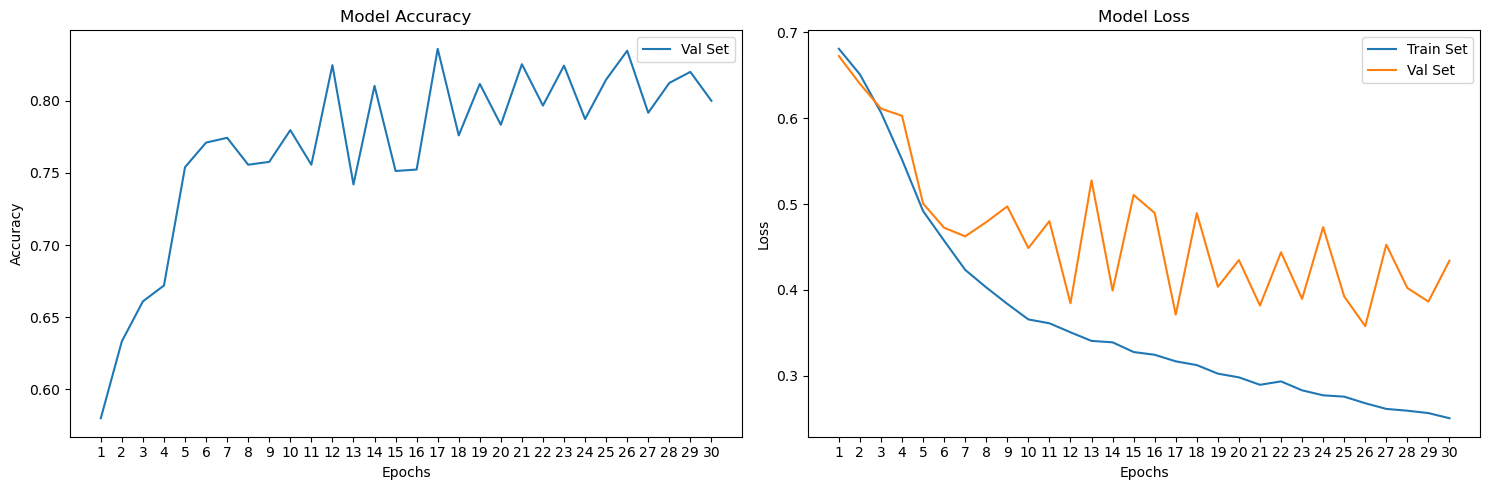

In [8]:
train_loss = []
val_accuracy = []
val_loss = []

for key, value, in history.items():
    if key.startswith("train_loss"):
        train_loss.append(value)
    if key.startswith("val_loss"):
        val_loss.append(value/len(video_val_dataloader))
    if key.startswith("val_correct"):
        val_accuracy.append(value/3000)

epochs = list(range(1,len(train_loss)+1))

import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(epochs, val_accuracy, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.xticks(ticks=range(1, len(epochs) + 1), 
           labels=[str(int(round(x))) for x in range(1, len(epochs) + 1)])


# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Set')
plt.plot(epochs, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.xticks(ticks=range(1, len(epochs) + 1), 
           labels=[str(int(round(x))) for x in range(1, len(epochs) + 1)])

plt.tight_layout()
plt.show()

## Classification Report

100%|██████████| 94/94 [00:05<00:00, 18.50it/s]


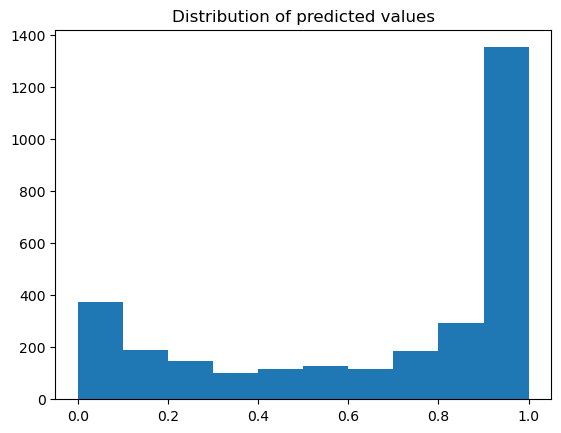

In [9]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

lstm_pretrained_cnn.eval()
y_true = []
p_hats = []

with torch.no_grad():
    for x,y in tqdm(video_val_dataloader):
        p_hat= lstm_pretrained_cnn(x)
        p_hats.append(p_hat.to("cpu"))
        y_true.append(y.to("cpu"))

y_true = torch.cat(y_true).numpy()
p_hats = torch.cat(p_hats).numpy()
plt.hist(p_hats)
plt.title("Distribution of predicted values")
plt.show()

In [10]:
print(f"Validation accuracy: {accuracy_score(y_true, p_hats > 0.5)}")

print(f"Area under the curve of validation set: {roc_auc_score(y_true, p_hats)}")

print("Confusion matrix on validation set with threshold 0.5\n",confusion_matrix(y_true,  p_hats > 0.5))

print("Classification Report on validation set, t = 0.5\n",classification_report(y_true, p_hats > 0.5))

Validation accuracy: 0.8
Area under the curve of validation set: 0.9524228888888889
Confusion matrix on validation set with threshold 0.5
 [[ 913  587]
 [  13 1487]]
Classification Report on validation set, t = 0.5
               precision    recall  f1-score   support

         0.0       0.99      0.61      0.75      1500
         1.0       0.72      0.99      0.83      1500

    accuracy                           0.80      3000
   macro avg       0.85      0.80      0.79      3000
weighted avg       0.85      0.80      0.79      3000



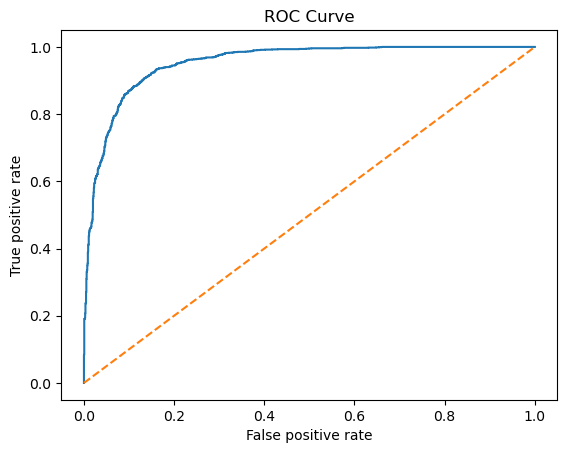

In [11]:
fpr, tpr, t = roc_curve(y_true, p_hats)

plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], "--")
plt.title("ROC Curve")
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.show()